In [ ]:
#With the assistance of Chat-GPT (last modified : 20260221)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform #for the fast simulation, not required

In [1]:
import h5py

f = h5py.File("blocks_0-99.h5", "r")
print(list(f.keys()))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [3]:
f['0']

<HDF5 group "/0" (1 members)>

In [4]:
print(list(f['0'].keys()))

['pos']


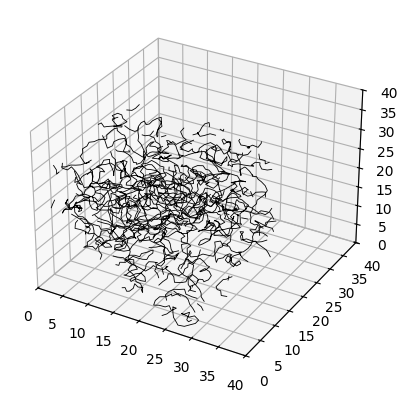

In [15]:

f = h5py.File("blocks_0-99.h5", "r")

mask = (
    (positions[:,0] > 0) & (positions[:,0] < 30) &
    (positions[:,1] > 0) & (positions[:,1] < 30) &
    (positions[:,2] > 0) & (positions[:,2] < 30)
)

indices = np.where(mask)[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 연속된 구간만 선으로 연결
start = 0
for i in range(1, len(indices)):
    if indices[i] != indices[i-1] + 1:
        segment = positions[indices[start:i]]
        ax.plot(segment[:,0], segment[:,1], segment[:,2],
                linewidth=0.6, color="black")
        start = i

# 마지막 구간
segment = positions[indices[start:]]
ax.plot(segment[:,0], segment[:,1], segment[:,2],
        linewidth=0.6, color="black")

ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_zlim(0,40)

plt.show()

In [16]:
step = 20   # 20개 monomer마다 하나씩 사용
coords = positions[::step]   # (2000, 3) 정도

In [20]:


f = h5py.File("blocks_0-99.h5", "r")

all_positions = []

for key in sorted(f.keys(), key=lambda x: int(x)):
    pos = f[key]['pos'][:]
    all_positions.append(pos)

all_positions = np.array(all_positions)

print(all_positions.shape)

(100, 40000, 3)


In [28]:
from numba import njit

@njit
def accumulate_contacts(accum, coords, cutoff2):
    n = coords.shape[0]

    for i in range(n):
        xi = coords[i,0]
        yi = coords[i,1]
        zi = coords[i,2]

        for j in range(i, n):
            dx = xi - coords[j,0]
            dy = yi - coords[j,1]
            dz = zi - coords[j,2]

            d2 = dx*dx + dy*dy + dz*dz

            if d2 < cutoff2:
                accum[i,j] += 1.0
                if i != j:
                    accum[j,i] += 1.0



In [29]:
N = all_positions.shape[1]
cutoff = 3.0
cutoff2 = cutoff * cutoff

contact_sum = np.zeros((N, N), dtype=np.float32)

for frame in all_positions:
    accumulate_contacts(contact_sum, frame, cutoff2)

contact_avg = contact_sum / len(all_positions)

In [43]:
def show_region(mat, x1, x2, y1, y2,
                log=True,
                cmap="coolwarm",
                vmin=-4,
                vmax=0):

    sub = mat[y1:y2, x1:x2]

    if log:
        sub = np.log10(sub + 1e-6)

    plt.figure(figsize=(6,6))
    plt.imshow(sub,
               cmap=cmap,
               origin="lower",
               interpolation="nearest",   # 🔥 빠르게
               vmin=vmin,
               vmax=vmax)

    plt.colorbar(label="log10(contact)" if log else "contact")
    plt.title(f"Region [{x1}:{x2}, {y1}:{y2}]")
    plt.show()

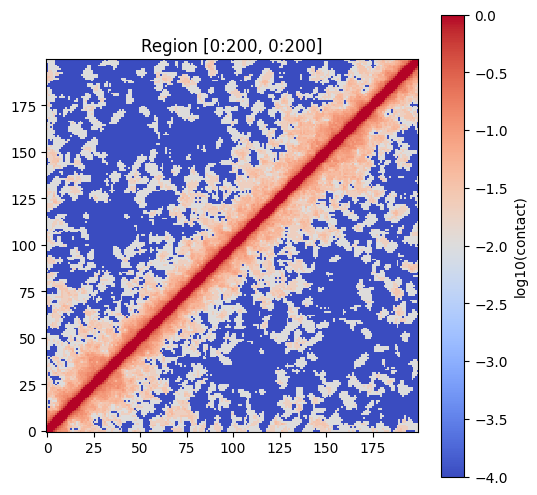

In [45]:
show_region(contact_avg, 0, 200, 0, 200)
#you can change the region manually